In [1]:
from typing import Annotated
from typing_extensions import TypedDict

In [2]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

In [3]:
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper = arxiv_wrapper)

wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wikipedia_tool = WikipediaQueryRun(api_wrapper = wikipedia_wrapper)

In [4]:
tools = [arxiv_tool, wikipedia_tool]

In [5]:
from langgraph.graph.message import add_messages

## Langgraph Application
class State(TypedDict):
    messages:Annotated[list, add_messages]

In [6]:
from langgraph.graph import StateGraph, START, END

In [7]:
graph_builder = StateGraph(State)

In [8]:
import os
from dotenv import load_dotenv

load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq

llm = ChatGroq(api_key=groq_api_key, model_name = "llama-3.1-8b-instant")

In [9]:
llm.invoke("Hello")

AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.010441973, 'prompt_time': 0.001555275, 'queue_time': 0.052746464, 'total_time': 0.011997248}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--6c4e52c3-00ac-4439-99ea-050877f3fd6f-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

In [10]:
llm_with_tools = llm.bind_tools(tools=tools)

In [11]:
def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [12]:
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)


graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

In [13]:
graph = graph_builder.compile()

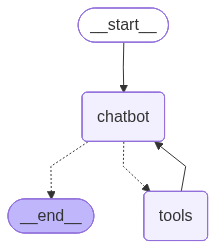

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

In [16]:
user_input = "What is Machine Learning?"

events = graph.stream(
    {"messages":[("user", user_input)]},
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is Machine Learning?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (vwr9cdjnz)
 Call ID: vwr9cdjnz
  Args:
    query: Machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline
================================== Ai Message ==================================
Tool Calls:
  wikipedia (vrpadgs4d)
 Call ID: vrpadgs4d
  Args:
    query: Machine learning subdiscipline
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Mac

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT